# Combining satellite data with tidal modelling using OTPS <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background

Ocean tides are the periodic rise and fall of the ocean caused by the gravitational pull of the moon and sun and the earth's rotation. 
Tides in coastal areas can greatly influence how these environments appear in satellite imagery as water levels vary by up to 12 metres (e.g. in northern Australia).
To be able to study environmental processes along Australia's coastline, it is vital to obtain data on tidal conditions at the exact moment each satellite image was acquired.

## Description
This notebooks demonstrates how to tidally tag remotely sensed imagery using functions from the [dea_coastaltools script](../Scripts/dea_coastaltools.py) so that images can be extracted or analysed by tidal stage (e.g. low, high, ebb, flow). 
These functions use the [OTPS TPXO8 tidal model](http://volkov.oce.orst.edu/tides/global.html) to calculate the height (relative to mean sea level, i.e. approximately equivalent to the Australian Height Datum or AHD) and stage of the tide at the exact moment each satellite image was acquired. 
This tidal model was previously used to produce DEA datasets including the [Intertidal Extents Model (ITEM)](http://dx.doi.org/10.4225/25/5a602cc9eb358), [High-Low Tide Composites (HLTC)](http://dx.doi.org/10.4225/25/5a615705d20f7), and the [National Intertidal Digital Elevation Model (NIDEM)](http://dx.doi.org/10.26186/5c4fc06a79f76).

The notebook demonstrates how to:

1. Load an example time series of satellite data
2. Use the `tidal_tag` function from `dea_coastaltools` to model tide heights for each satellite observation
3. Use tide height data to produce median composites of the coast at low and high tide
4. Swap a dataset's dimensions to compute a rolling median along the `tide_height` dimension
5. Compute ebb or flow tide phase data to determine whether water levels were rising or falling in each satellite observation
6. Use the `tidal_stats` function to evaluate any biases in the tidal conditions observed by a satellite

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.coastal import tidal_tag, tidal_stats


In [87]:
smartline = gpd.read_file('/g/data/r78/DEACoastlines/input_data/Smartline.gdb')

In [88]:
smartline_filtered = smartline.loc[smartline.ABSAMP_ID != ' ']

In [98]:
smartline_dissolved = smartline_filtered.dissolve(by='ABSAMP_ID', 
                                                  aggfunc=lambda x: pd.Series.mode(x)[0])

In [99]:
smartline_dissolved['geometry'] = smartline_dissolved.representative_point()

In [117]:
absamp_database_df = pd.read_csv('absamp_database.csv').drop(['BEACHID', 'GEOM', 'BEACHID.1'], axis=1)
absamp_database_df.head()

,BEACH_KEY,BEACH_NAME,LENGTH,ORIENTATION,EMBAYMENTISATION,MEAN_BARS,MODAL_WAVE_HEIGHT,MEAN_WAVE_PERIOD,RDID,TIID,STATE,IMCRA,MARINEREGION,NRMZONE,LGA,CMA,LATITUDE,LONGITUDE
0,wa1498,Fourteen Mile Camp (S 1),0.30,275.0,1.0,NaN,1.0,12,403.0,9704,WA,Ningaloo,NaN,NaN,Carnarvon,GASCOYNE-NORTH WEST CAPE,-23.30076,113.79521
1,sa0187,Cape Jervis harbour,0.04,180.0,0.1,NaN,0.3,12,378.0,4230,SA,NaN,NaN,Adelaide and Mount Lofty Ranges,Yankalilla,ADELAIDE HILLS,-35.60513,138.09483
2,wa0887,Mindarie Keys (N 3),0.10,260.0,0.9,NaN,0.9,12,403.0,9093,WA,NaN,NaN,Swan,Wanneroo,PERTH-MANDURAH,-31.68483,115.69871
3,sa0545,Port Broughton (north),1.00,275.0,0.3,NaN,0.1,4,397.0,4604,SA,NaN,NaN,Northern and Yorke,Barunga West,NORTH ST VINCENT-SPENCER GULF,-33.58919,137.93181
4,sa0620,Windmill Beach,12.80,155.0,1.0,NaN,0.4,6,397.0,4679,SA,Spencer Gulf,NaN,Eyre Peninsula,Franklin Harbour,NORTH ST VINCENT-SPENCER GULF,-33.77326,136.91296


In [146]:
smartline_merged = smartline_dissolved.drop(['Shape_Length'], axis=1).join(absamp_database_df.set_index('BEACH_KEY'))
smartline_merged.index.name = 'ABSAMP_ID'

In [147]:
smartline_merged.to_crs('EPSG:4326').to_file('ABSAMP.geojson', driver='GeoJSON')

In [148]:
smartline_merged = gpd.read_file('ABSAMP.geojson').set_index('ABSAMP_ID')

In [150]:
smartline_merged.columns

Index(['BASELINE', 'BASESCALE', 'BASEFEAT', 'AUSCSTFID', 'UPDATED',
       'BACKPROX_N', 'BACKPROX_V', 'BACKPROX_R', 'BACKPROX_S', 'BACKDIST_N',
       'BACKDIST_V', 'BACKDIST_R', 'BACKDIST_S', 'BACKPROF_N', 'BACKPROF_V',
       'BACKPROF_R', 'BACKPROF_S', 'INTERTD1_N', 'INTERTD1_V', 'INTERTD1_R',
       'INTERTD1_S', 'INTERTD2_N', 'INTERTD2_V', 'INTERTD2_R', 'INTERTD2_S',
       'INTSLOPE_N', 'INTSLOPE_V', 'INTSLOPE_R', 'INTSLOPE_S', 'SUBTID1_N',
       'SUBTID1_V', 'SUBTID1_R', 'SUBTID1_S', 'SUBTID2_N', 'SUBTID2_V',
       'SUBTID2_R', 'SUBTID2_S', 'EXPOSURE_N', 'EXPOSURE_V', 'EXPOSURE_R',
       'EXPOSURE_S', 'GEOLOGY1_N', 'GEOLOGY1_V', 'GEOLOGY1_R', 'GEOLOGY1_S',
       'GEOLOGY2_N', 'GEOLOGY2_V', 'GEOLOGY2_R', 'GEOLOGY2_S', 'MUDDY_N',
       'MUDDY_V', 'MUDDY_L', 'SANDY_N', 'SANDY_V', 'SANDY_L', 'DUNES_N',
       'DUNES_V', 'DUNES_L', 'COARSED_N', 'COARSED_V', 'COARSED_L',
       'UNDIFSED_N', 'UNDIFSED_V', 'UNDIFSED_L', 'SOFTROCK_N', 'SOFTROCK_V',
       'SOFTROCK_L', 'HARDROCK_N

In [157]:
# ymax, xmin = -15.25732005, 122.42411987
# ymin, xmax = -17.26544608, 125.06864248


# ymax, xmin = -10.36988882, 116.03228071
# ymin, xmax = -22.05040764, 133.32353552

beaches_nw = smartline_merged  #.cx[xmin:xmax, ymin:ymax]
beaches_nw['x'] = beaches_nw.geometry.x
beaches_nw['y'] = beaches_nw.geometry.y
# beaches_nw.plot()
beaches_nw = beaches_nw.drop('geometry', axis=1).copy()

In [159]:
# beaches_nw 

In [8]:
import pandas as pd
import numpy as np
from otps import TimePoint
from otps import predict_tide


def astronomical_tide_range(tidepost_lon=155, 
                            tidepost_lat=-32, 
                            time_start='2000', 
                            time_end='2001', 
                            modelled_freq='12h',
                            return_obs=False):

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]

    # Get coarse statistics on all and observed tidal ranges
    all_mean = np.mean(all_tideheights)
    all_min, all_max = np.quantile(all_tideheights, [0.0, 1.0])

    # Calculate tidal range
    all_range = (all_max - all_min)
    
    if return_obs:
        obs_df = pd.DataFrame({'tide_m': all_tideheights}, index=all_datetimes) 
        
        return {'tide_range': all_range, 'tide_min': all_min, 'tide_max': all_max}, obs_df  
    
    else:
        return {'tide_range': all_range, 'tide_min': all_min, 'tide_max': all_max}




In [96]:

y, x = -17.291903, 123.601882
out = astronomical_tide_range(tidepost_lon=x, 
                                        tidepost_lat=y,
                                        time_start='1990', 
                                        time_end='2020', 
                                        modelled_freq='2h',
                       return_obs=True)

In [97]:
out[1].max() - out[1].min()

tide_m    11.916
dtype: float64

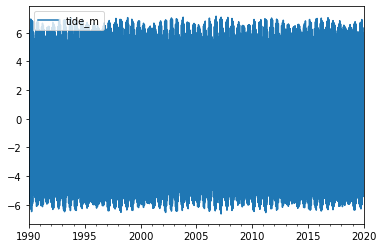

In [11]:
out[1].plot()

131485

In [67]:
import numpy as np
from scipy.signal import argrelextrema

n = out[1].shape[0]
time = out[1].head(n).index.values
tides = out[1].head(n).tide_m.values

# for local maxima
maxima = argrelextrema(tides, np.greater)[0]
maxima_time = [time[i] for i in maxima]
maxima_tides = [tides[i] for i in maxima]

# for local minima
minima = argrelextrema(tides, np.less)[0]
minima_time = [time[i] for i in minima]
minima_tides = [tides[i] for i in minima]

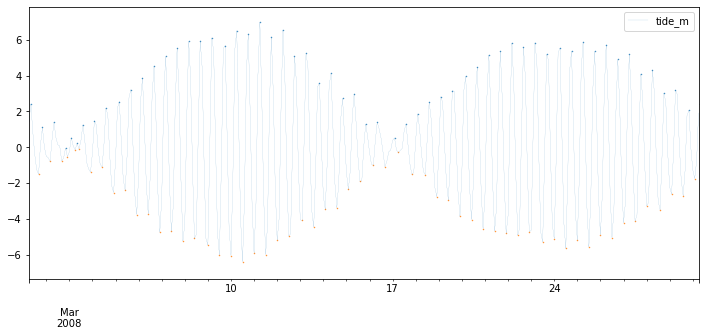

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_data = out[1].loc[slice(np.datetime64('2008-03-01T06:00:00.000000000'), np.datetime64('2008-03-30T06:00:00.000000000'))]
plot_data.plot(ax=ax, linewidth=0.1)
ax.scatter(maxima_time, maxima_tides, s=0.2)
ax.scatter(minima_time, minima_tides, s=0.2)


In [79]:
diff = np.array(maxima_tides[:len(minima_tides)]) - np.array(minima_tides)

In [91]:
diff[slice(np.argmax(diff)-10, np.argmax(diff)+10)]

array([ 6.282,  8.289,  8.786, 10.282, 10.605, 11.178, 11.192, 11.134,
       12.523, 12.377, 13.387, 12.079, 12.543, 10.273, 10.203,  7.675,
        8.581,  6.192,  6.366,  3.65 ])

In [82]:
maxima_time[13007]

numpy.datetime64('2008-03-11T06:00:00.000000000')

In [182]:
def tide_apply(i):
    try:
        tides = astronomical_tide_range(tidepost_lon=i.x, 
                                        tidepost_lat=i.y,
                                        time_start='1990', 
                                        time_end='2020', 
                                        modelled_freq='2h')        
    except:
        tides = {'tide_range': np.nan, 'tide_min': np.nan, 'tide_max': np.nan}
    
    return pd.Series(tides)

In [183]:
import dask.dataframe as dd

# Convert pandas dataframe to dask dataframe
data_dd = dd.from_pandas(beaches_nw, npartitions=15)

In [184]:
# Apply custom function to each partition, parallelising across cores
out_df = (data_dd
          .map_partitions(lambda df: df.apply(tide_apply, axis=1))
          .compute(scheduler='processes'))

In [185]:
out_df.dropna().to_csv('ABSAMP_tides.csv')

In [186]:
smartline_tides = smartline_merged.join(out_df).drop(['x', 'y'], axis=1)

smartline_tides.to_file('ABSAMP_tides_2hr.geojson', driver='GeoJSON')

In [181]:
smartline_tides.tide_range

ABSAMP_ID
nsw001    2.107
nsw006    2.095
nsw007    2.095
nsw008    2.095
nsw009    2.094
          ...  
waR59     0.872
waR60     0.873
waR61     0.873
waR62     0.873
waR63     0.873
Name: tide_range, Length: 12102, dtype: float64

In [ ]:
outputs = []
fails = []

for i, row in beaches_nw.iterrows():
    
    try: 
        x, y = list(row.geometry.coords)[0]
        tides = astronomical_tide_range(tidepost_lon=x, 
                                        tidepost_lat=y,
                                        time_start='2000', 
                                        time_end='2020', 
                                        modelled_freq='5h')
        tides['id'] = i
        print(tides)
        outputs.append(tides['id'])
        
    except:
        print(f'Failed: {i}')
        fails.append(i)
        

### Connect to the datacube


In [ ]:
dc = datacube.Datacube(app='Tidal_modelling')


### Set up data query

First we set up a query to define the area, time period and other parameters required for loading data.
In this example, we will load 30 years of Landsat 5, 7 and 8 data for an intertidal beach near West Hill Island south of Mackay in Queensland.
We load the `'nbart_red', 'nbart_green', 'nbart_blue'` bands so that we can plot the data as true colour imagery.

> The `dask_chunks` parameter allows us to [use Dask](https://examples.dask.org/xarray.html) to lazily load data rather than load data directly into memory, which can take a long time and large amounts of memory.
Lazy loading can be a very useful approach for when you need to load large amounts of data without crashing your analysis.
In coastal applications, it allows us to load (using either `.compute()` or by plotting our data) only a small subset of observations from our entire time series (e.g. only low or high tide observations) without having to load the entire dataset into memory first, which can greatly decrease processing times.

> For more information about using Dask, refer to the [Parallel processing with Dask](07_Parallel_processing_with_Dask.ipynb) notebook.

In [ ]:
# Set up data load query
query = {'x': (149.4, 149.53),
         'y': (-21.71, -21.85),
         'time': ('1988', '2018'),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
         'output_crs': 'EPSG:32755',
         'resolution': (-30, 30),
         'group_by': 'solar_day',
         'dask_chunks': {}}

We can preview the area that we will load data for:

In [ ]:
display_map(x=query['x'], y=query['y'])

## Load satellite time-series

To obtain some satellite data to analyse, we use the `load_ard` import a time series of Landsat 5, 7 and 8 observations as an `xarray.Dataset`.
The input data does not need to be from Landsat: any remotely-sensed imagery with timestamps and spatial coordinates provide enough data to run the tidal model. 

In [ ]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              ls7_slc_off=False,
              **query)

# Print output data
ds

## Model tide heights for each observation

We use the `tidal_tag` function from `dea_coastaltools` to associate each satellite observation in our timeseries with a tide height relative to mean sea level (i.e. approximately equivalent to the Australian Height Datum or AHD).
This function uses the time and date of acquisition and the geographic location of each satellite observation as inputs to the OSU Tidal Prediction Software (OTPS) tidal model.
From [Sagar et al. 2015](https://www.sciencedirect.com/science/article/pii/S0034425717301591):

> The **OTPS TPX08** tidal model consists of a multi-resolution bathymetric grid solution, with a 1/6° solution in the global open ocean, and a 1/30° local resolution solution to improve modelling in complex shallow water environments. The OTPS model is based on a system of linear partial differential equations, called Laplace's tidal equations, parametrised with nine harmonic tidal constituents. The model is fitted to track-averaged TOPEX/Poseidon altimeter data collected from 1992 to 2016 and Jason-1 (Poseidon 2) altimeter data from 2002 to 2013, enabling estimation of the tidal height and harmonic constituents at discrete temporal epochs and spatial locations.

In [ ]:
# Model tide heights
ds_tidal = tidal_tag(ds)

# Print output data
ds_tidal


The function will automatically select a tide modelling location based on the dataset centroid.
It will then output modelled tide heights as a new `tide_height` variable in the `xarray.Dataset` (the variable should appear under `Data variables` above).

We can easily plot this new variable to inspect the range of tide heights observed by the satellites in our timeseries.
In this example, our observed tide heights range from approximately -3.0 to 4.0 m relative to Mean Sea Level:

In [ ]:
ds_tidal.tide_height.plot(linewidth=0.5)

### Example tide height analysis
To demonstrate how tidally tagged images can be used to produce composites of high and low tide 
imagery, we can compute the lowest 5% and highest 5% percent of tide heights, and use these to filter our observations. 
We can then combine and plot these filtered observations to visualise what the landscape looks like at low and high tide:

In [ ]:
# Calculate the lowest and highest 5% of tides
lowest_5, highest_5 = ds_tidal.tide_height.quantile([0.05, 0.95]).values

# Filter our data to low and high tide observations
filtered_low = ds_tidal.where(ds_tidal.tide_height <= lowest_5, drop=True)
filtered_high = ds_tidal.where(ds_tidal.tide_height >= highest_5, drop=True)

# Take the simple median of each set of low and high tide observations to 
# produce a composite (alternatively, observations could be combined 
# using a geomedian to keep band relationships consistent)
median_low = filtered_low.median(dim='time', keep_attrs=True)
median_high = filtered_high.median(dim='time', keep_attrs=True)

# Combine low and high tide medians into a single dataset and give 
# each layer a meaningful name
ds_highlow = xr.concat([median_low, median_high], dim='tide_height')
ds_highlow['tide_height'] = ['Low tide', 'High tide']

# Plot low and high tide medians side-by-side
rgb(ds_highlow, col='tide_height')

### Swapping dimensions

The `tidal_tag` function allows you to use tide heights as the primary dimension in the dataset, rather than time.
Setting `swap_dims=True` will swap the `time` dimension in the original `xarray.Dataset` to the new `tide_height` variable.

In [ ]:
# Model tide heights
ds_tidal = tidal_tag(ds, swap_dims=True)

# Print output data
ds_tidal

The dataset now contains three dimensions: `tide_height`, `x` and `y`.
This can make it easier to analyse the data with respect to tide, e.g. computing a rolling median by tide height (e.g. along the `tide_height` dimension):

In [ ]:
# First we need to update the chunks used by Dask to allow us to do a 
# rolling median without having to load all our data into memory first
ds_rechunked = ds_tidal.chunk(chunks={'tide_height': 15})

# Compute a rolling median that will go through every satellite 
# observation, and take the median of that timestep and its 15 neighbours
ds_rolling = ds_rechunked.rolling(tide_height=15, 
                                  center=True, 
                                  min_periods=1).median()

# Plot the lowest, 500th and highest tide rolling median image
rgb(ds_rolling, index_dim='tide_height', index=[0, 500, -1])

## Modelling ebb and flow tidal phases

The `tidal_tag` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`.
This is achieved by comparing tide heights 15 minutes before the before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

In [ ]:
# Model tide heights
ds_tidal = tidal_tag(ds, ebb_flow=True)

# Print output data
ds_tidal

We now have data giving us the both the tide height and tidal phase ('ebb' or 'flow') for every satellite image:

In [ ]:
ds_tidal[['time', 'tide_height', 'ebb_flow']].to_dataframe()

We could for example use this data to filter our observations to keep ebbing phase observations only:

In [ ]:
ds_tidal.where(ds_tidal.ebb_flow == 'Ebb', drop=True)

## Evaluating observed vs. all modelled tide heights

The complex behaviour of tides mean that a sun synchronous sensor like Landsat [does not observe the full range of the tidal cycle at all locations](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).
Biases in the proportion of the tidal range observed by satellites can prevent us from obtaining data on areas of the coastline exposed or inundated at the extremes of the
tidal range. 
This can risk gaining misleading insights into the true extent of the area of the coastline affected by tides, and make it difficult to compare high or low tide images fairly in different locations.

The `tidal_stats` function can assist in evaluating how the range of tides observed by satellites compare to the full tidal range.
It works by using the OTPS tidal model to model tide heights at a regular interval (every two hours by default) across the entire time period covered by the input satelliter timeseries dataset.
This is then compared against the tide heights in observed by the satellite and used to calculate a range of statistics and a plot that summarises potential biases in the data.

> For a more detailed discussion of the issue of tidal bias in sun-synchronous satellite observations of the coastline, refer to the ['Limitations and future work' section in Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).


In [ ]:
out_stats = tidal_stats(ds)

The function also outputs a `pandas.Series` object containing a set of statistics that compare the observed vs. full modelled tidal ranges.
These statistics include: 

* **tidepost_lat:** latitude used for modelling tide heights
* **tidepost_lon:** longitude used for modelling tide heights
* **observed_min_m:** minimum tide height observed by the satellite (in metre units)
* **all_min_m:** minimum tide height from full modelled tidal range (in metre units)
* **observed_max_m:** maximum tide height observed by the satellite (in metre units)
* **all_max_m:** maximum tide height from full modelled tidal range (in metre units)
* **observed_range_m:** tidal range observed by the satellite (in metre units)
* **all_range_m:** full modelled tidal range (in metre units)
* **spread_m:** proportion of the full modelled tidal range observed by the satellite (see [Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3))
* **low_tide_offset:** proportion of the lowest tides never observed by the satellite (see [Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3))
* **high_tide_offset:** proportion of the highest tides never observed by the satellite (see [Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3))
* **observed_slope:** slope of any relationship between observed tide heights and time
* **all_slope:** slope of any relationship between all modelled tide heights and time
* **observed_pval:** significance/p-value of any relationship between observed tide heights and time
* **all_pval:** significance/p-value of any relationship between all modelled tide heights and time

In [ ]:
out_stats

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)